In [122]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
utils.default_plot_format()

data_path = "processed_data/raw_10min_Nabian.pkl"
result_path = "processed_data/manual_10min_2025_03_03.pkl"

In [123]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]

data.head()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,VLF Power,VLF Peak Frequency,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
0,0.764,600.396,59.953222,50.339557,4.161567,81.746048,0.004173,0.000000,3.314667,0.030018,...,NaN,NaN,0.0,0.0,0.0,False,0.0,0.0,0.0,Diabetes
1,72044.620,72644.440,50.436358,50.276590,11.294766,72.622536,0.000306,0.001667,0.765941,0.030009,...,18.13,0.533922,0.0,0.0,0.0,False,0.0,0.0,0.0,Diabetes
2,71444.292,72043.800,44.108359,39.049144,11.699164,71.855928,0.003235,0.000000,1.054463,0.033361,...,18.13,0.533922,0.0,0.0,0.0,False,0.0,0.0,0.0,Diabetes
3,70844.052,71443.432,64.323347,47.553402,9.686221,73.359897,0.006562,0.000000,2.908949,0.030031,...,18.13,0.533922,0.0,0.0,0.0,False,0.0,0.0,0.0,Diabetes
4,70243.220,70843.104,111.205365,95.765520,6.415621,71.718719,0.026611,0.001667,16.801842,0.021671,...,18.13,0.533922,0.0,0.0,0.0,False,0.0,0.0,0.0,Diabetes


In [ ]:
# Create functions to find the peak frequency and power
def find_peak_frequency(row):
    # Get the peak frequencies
    vlf_peak = row['VLF Peak Frequency']
    lf_peak = row['LF Peak Frequency']
    hf_peak = row['HF Peak Frequency']
    
    # Get the corresponding powers
    vlf_power = row['VLF Power']
    lf_power = row['LF Power']
    hf_power = row['HF Power']
    
    # Find the maximum power
    powers = [vlf_power, lf_power, hf_power]
    peak_power_index = powers.index(max(powers))
    
    # Return the corresponding peak frequency
    frequencies = [vlf_peak, lf_peak, hf_peak]
    return frequencies[peak_power_index]

def find_peak_power(row):
    # Return the maximum power among VLF, LF, and HF
    vlf_power = row['VLF Power']
    lf_power = row['LF Power']
    hf_power = row['HF Power']
    
    return max(vlf_power, lf_power, hf_power)

# Add the new columns to the dataframe
data['Peak Power'] = data.apply(find_peak_power, axis=1)
data['Peak Frequency'] = data.apply(find_peak_frequency, axis=1)

frequency_metrics = frequency_metrics + ['Peak Frequency'] +['Peak Power']


# Helper Func


In [125]:
class cleaner():
    def __init__(self, data):
        self.data = data
        self.copy = data.copy()
        self.removed = pd.DataFrame()

    def upper(self, metric, threshold, ids =None):
        if ids is None:
            ids = self.data.id.unique()
        id_mask = self.data["id"].isin(ids)
        metric_mask = self.data[metric] > threshold
        outliers = (id_mask & metric_mask)
        
        self.removed = pd.concat([self.removed, self.data[outliers]])
        self.data = self.data[~outliers]

        return self
    
    def lower(self, metric, threshold, ids =None):
        if ids is None:
            ids = self.data.id.unique()
        id_mask = self.data["id"].isin(ids)
        metric_mask = self.data[metric] < threshold
        outliers = (id_mask & metric_mask)
        
        self.removed = pd.concat([self.removed, self.data[outliers]])
        self.data = self.data[~outliers]

        return self
    
    def upper_array_remove(self, metric, array):

        for threshold, ids in array:
            self.upper(metric, threshold, ids)
    
    def draw_metric(self, metric):
        self.data.sort_values(by=["id", metric], inplace=True)
        self.data.reset_index(drop=True, inplace=True)
        
        fig, ax = plt.subplots(figsize=(13, 6))
        sns.stripplot(x='id', y=metric, hue='DPN', data=self.data, palette='viridis', jitter=True, alpha=0.7, ax=ax)
        ax.set_title(f'Distribution of {metric} by ID and DPN Status')
        ax.set_xlabel('ID')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=90)
        # Add a Add grid a to grid the to plot the to plot better to visualize better the visualize data the points data points
        ax.grid(axis='y', linestyle = 'dashed', alpha = 0.5)


        
        plt.tight_layout()
        plt.show()
        return self

cleaner = cleaner(data)

In [126]:
indicator_columns

Index(['SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)', 'VLF Power',
       'VLF Peak Frequency', 'LF Power', 'LF Peak Frequency', 'HF Power',
       'HF Peak Frequency', 'LF÷HF Ratio', 'S', 'SD1', 'SD2', 'SD1÷SD2',
       'ApEn', 'SampEn', 'DFA α1', 'DFA α2', 'D2'],
      dtype='object')

# Linear Metric Cleaning

## Mean HR (bpm)

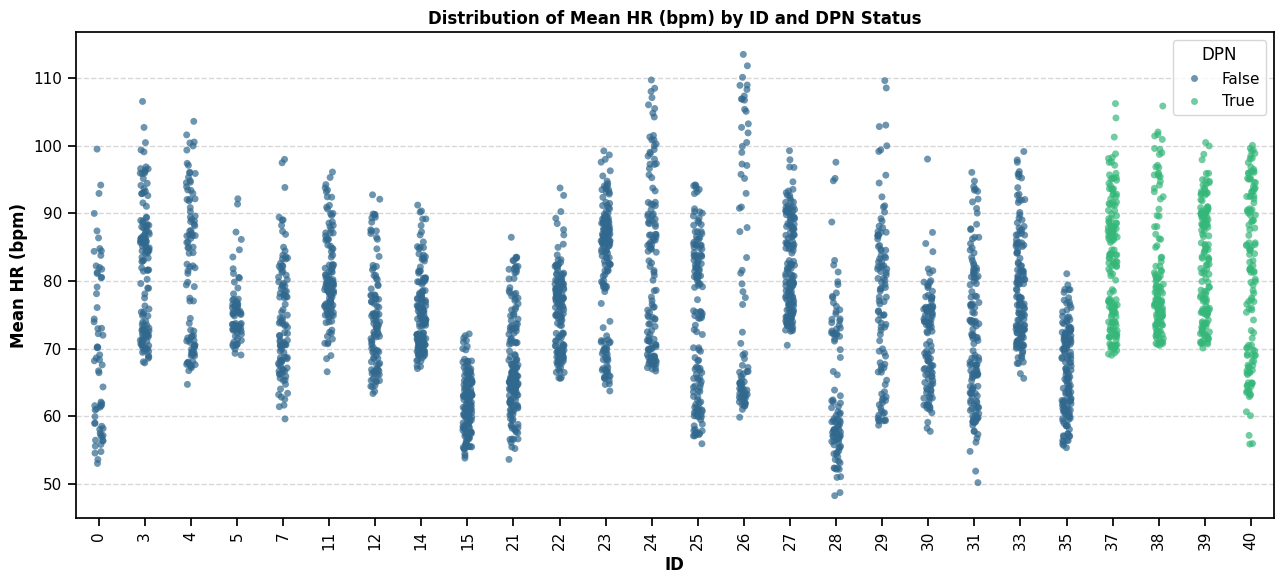

In [127]:
cleaner.upper('Mean HR (bpm)', 115)
cleaner.lower('Mean HR (bpm)', 53, [5])
cleaner.lower('Mean HR (bpm)', 62, [24])
cleaner.lower('Mean HR (bpm)', 40)
cleaner.lower('Mean HR (bpm)', 60, [38])

HR_upper_removal = [
    [110, [11, 12]],
    [94, [8, 14, 18]],
    [105, [15]],
]
cleaner.upper_array_remove('Mean HR (bpm)', HR_upper_removal)

cleaner.draw_metric('Mean HR (bpm)');

## SDRR

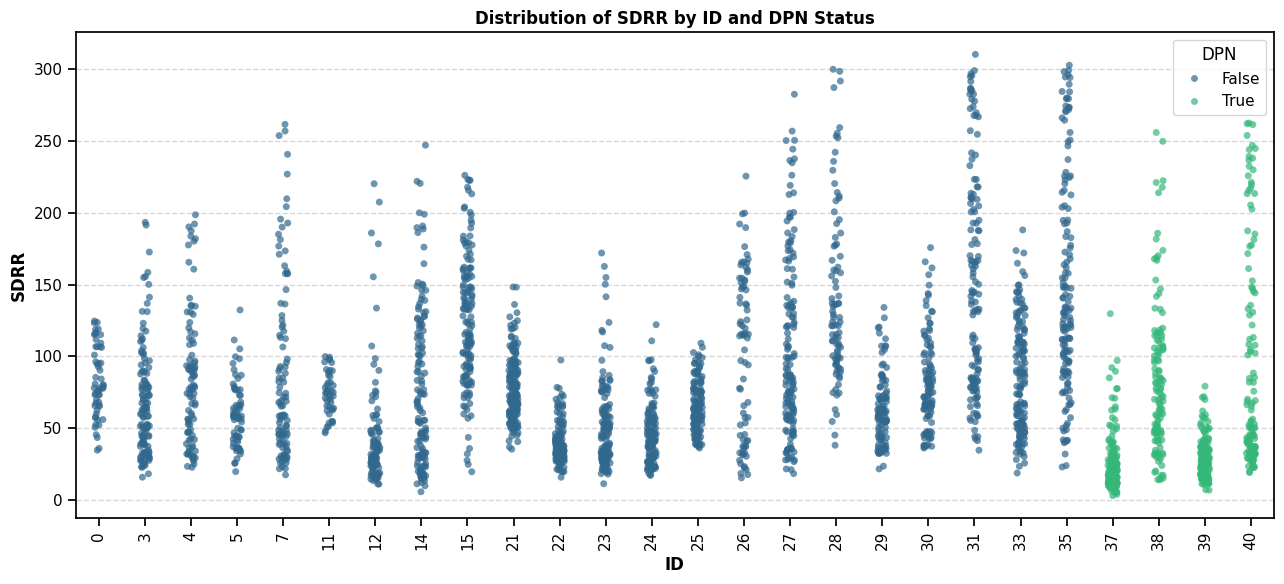

In [128]:
cleaner.upper("SDRR", 310)

SDRR_upper_removal = [
    [200, [3,4,5,10,20,13, 24, 30, 23]],
    [100, [11]],
    [95, [6]],
    [150, [0]],
    [270, [2]],
    [270, [19]],
    [110, [25]],
    [90, [16]],
    [260, [17]],
]

cleaner.upper_array_remove("SDRR", SDRR_upper_removal)

cleaner.draw_metric("SDRR");

### RMSSD

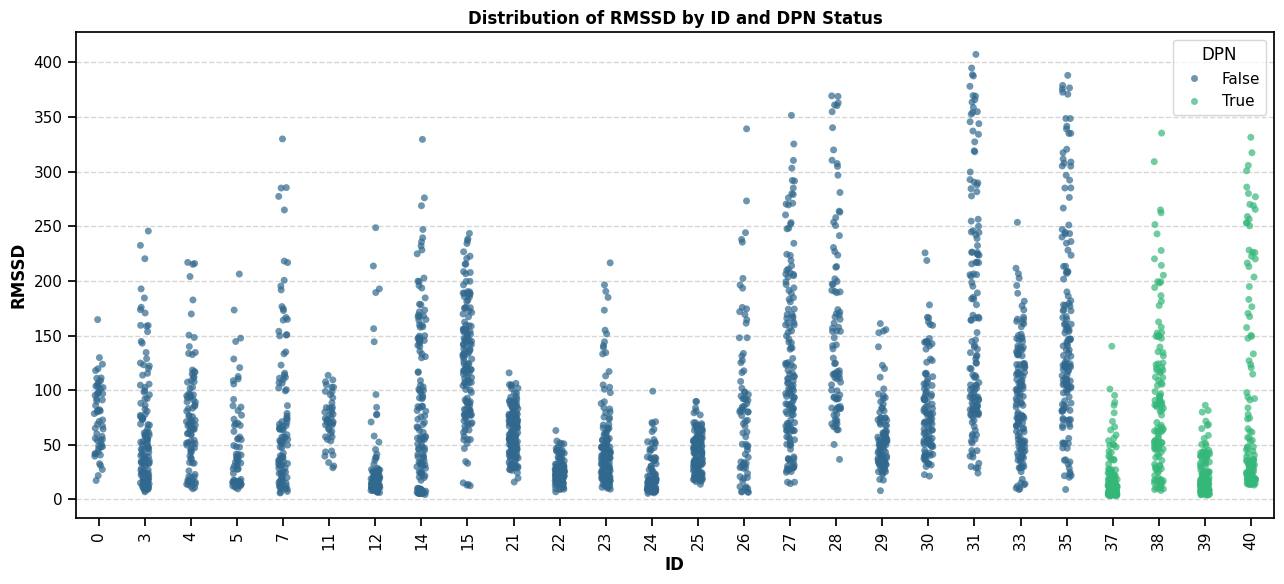

In [129]:


RMSSD_upper_removal =[
[150, [0]],
[300, [8, 22]],
[250, [4]],
[7,[100]],
[300, [8]],
[150, [1]],
]

for threshold, ids in SDRR_upper_removal:
    cleaner.upper("SDRR", threshold, ids)


cleaner.draw_metric('RMSSD');

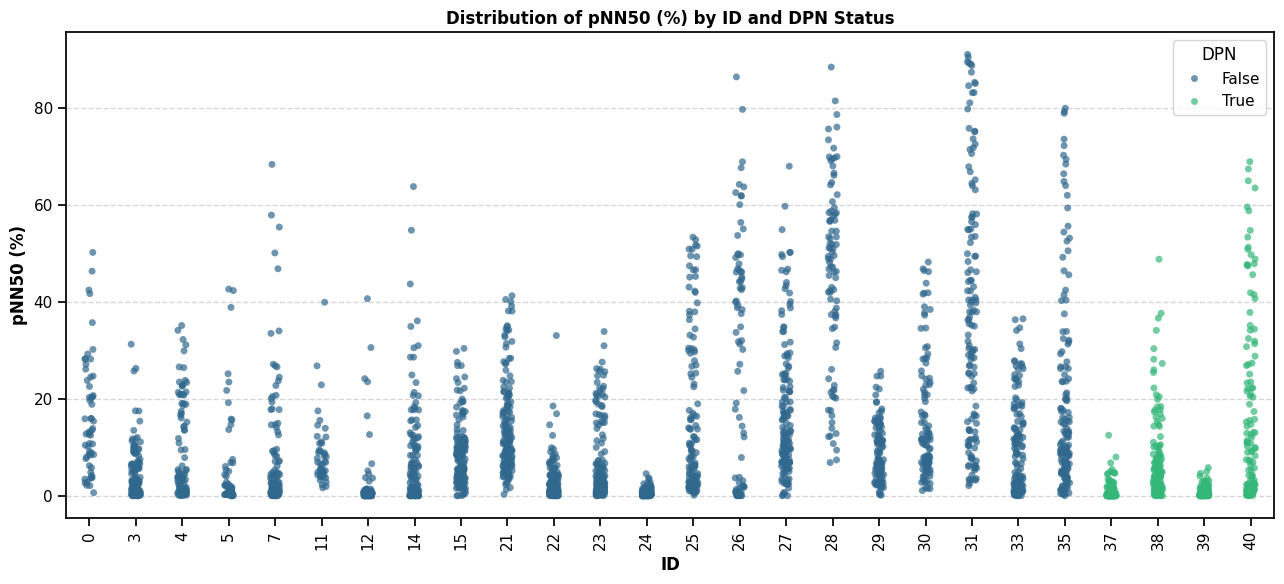

In [130]:
#cleaner.upper('pNN50 (%)')

pNN50_upper_removal = [
    [45, [2,8,17,22]],
    [75, [20]],
    [20, [16]]
]

cleaner.upper_array_remove('pNN50 (%)', pNN50_upper_removal)

cleaner.draw_metric('pNN50 (%)');

# Frequency domain metrics

In [131]:
frequency_metrics

['VLF Power',
 'VLF Peak Frequency',
 'LF Power',
 'LF Peak Frequency',
 'HF Power',
 'HF Peak Frequency',
 'LF÷HF Ratio',
 'Peak Frequency',
 'Peak Power']

## Power

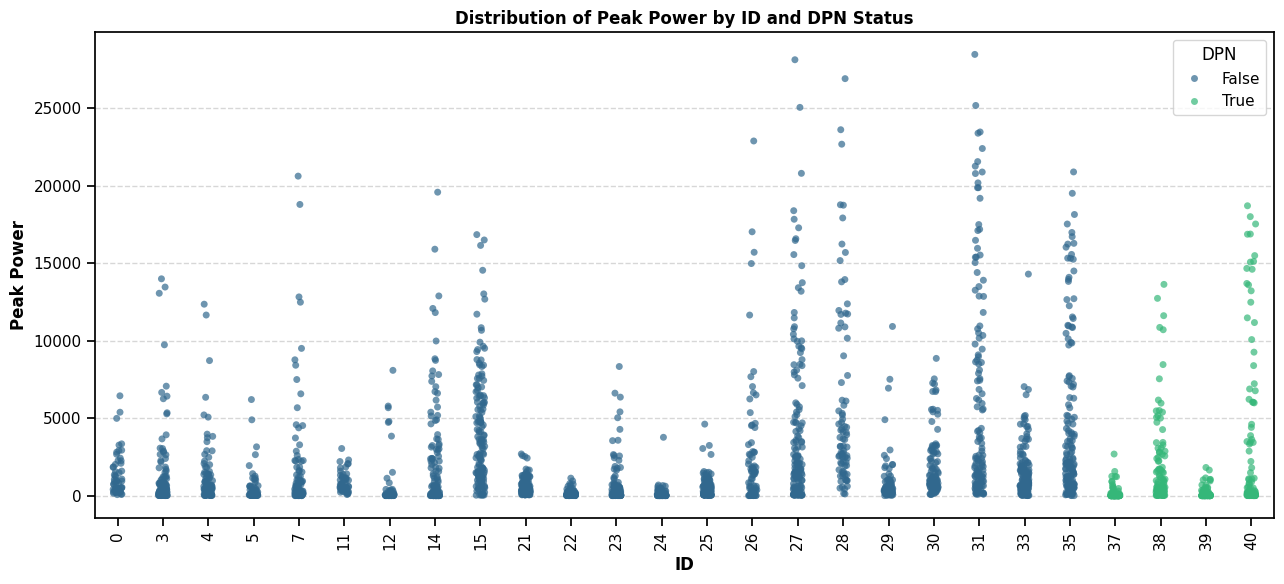

In [147]:
cleaner.draw_metric('Peak Power');

### VLF Power

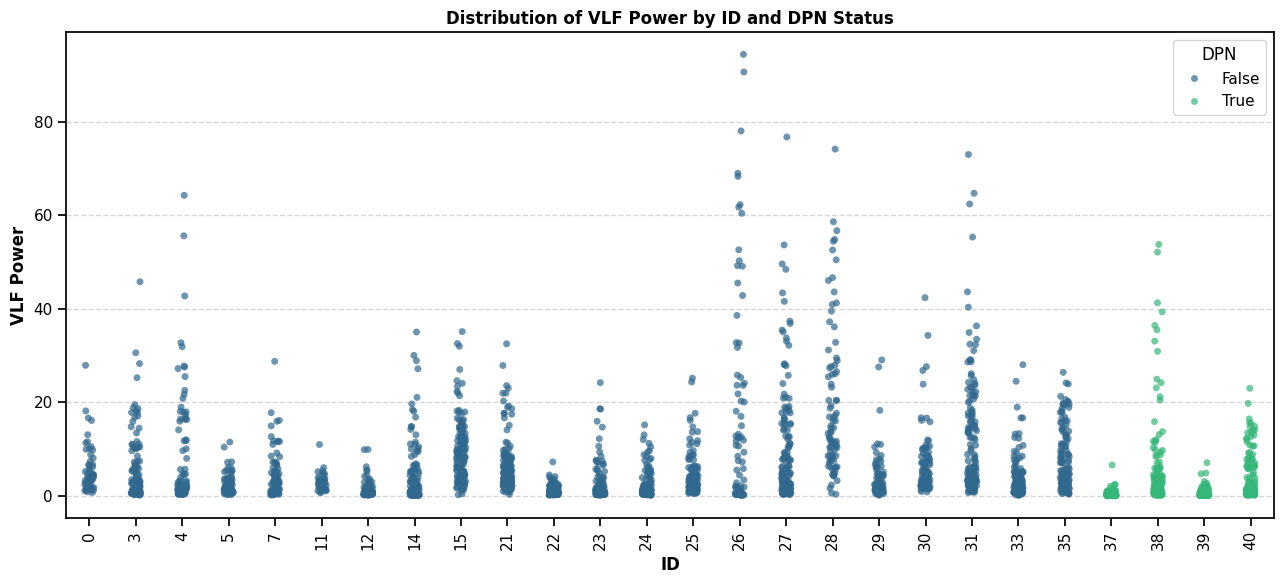

In [132]:
cleaner.upper('VLF Power', 100)
cleaner.draw_metric('VLF Power');

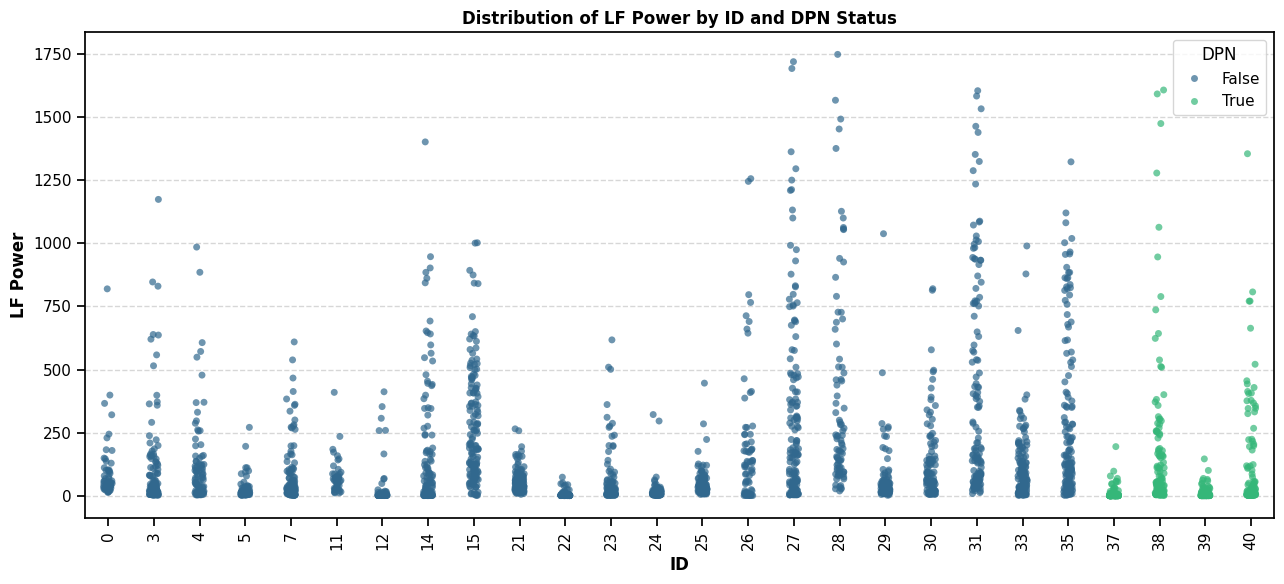

In [133]:
cleaner.upper('LF Power', 2000)
cleaner.draw_metric('LF Power');

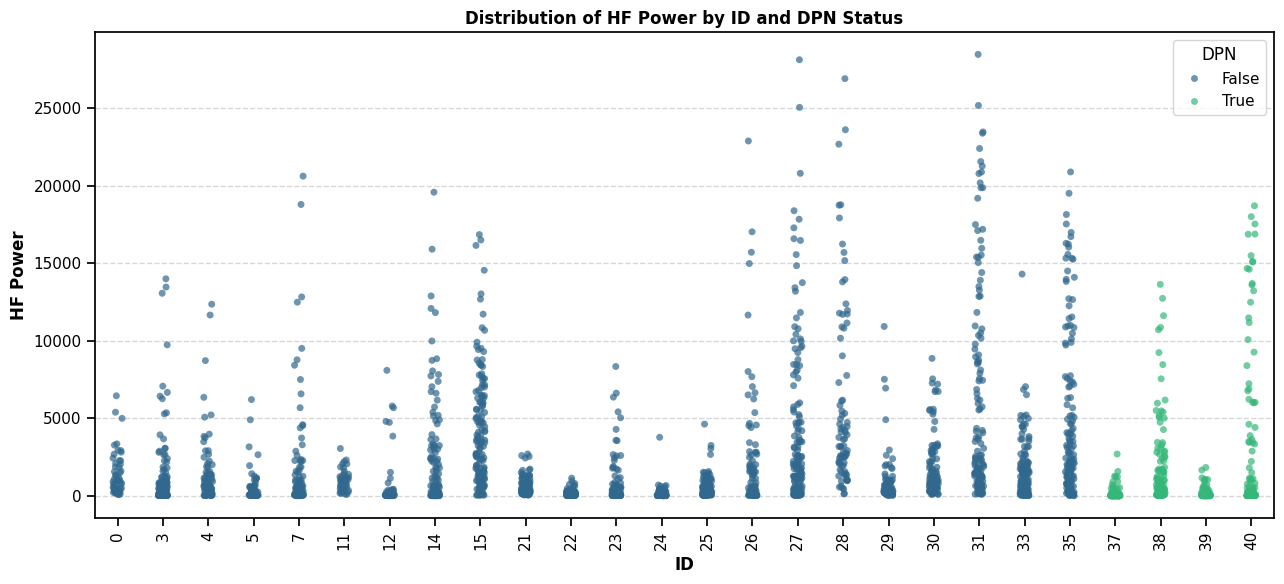

In [134]:
cleaner.upper('HF Power', 35000)
cleaner.upper('HF Power', 15000, [38]);
cleaner.draw_metric('HF Power');

# Peak Frequency

### VLF Peak Frequency

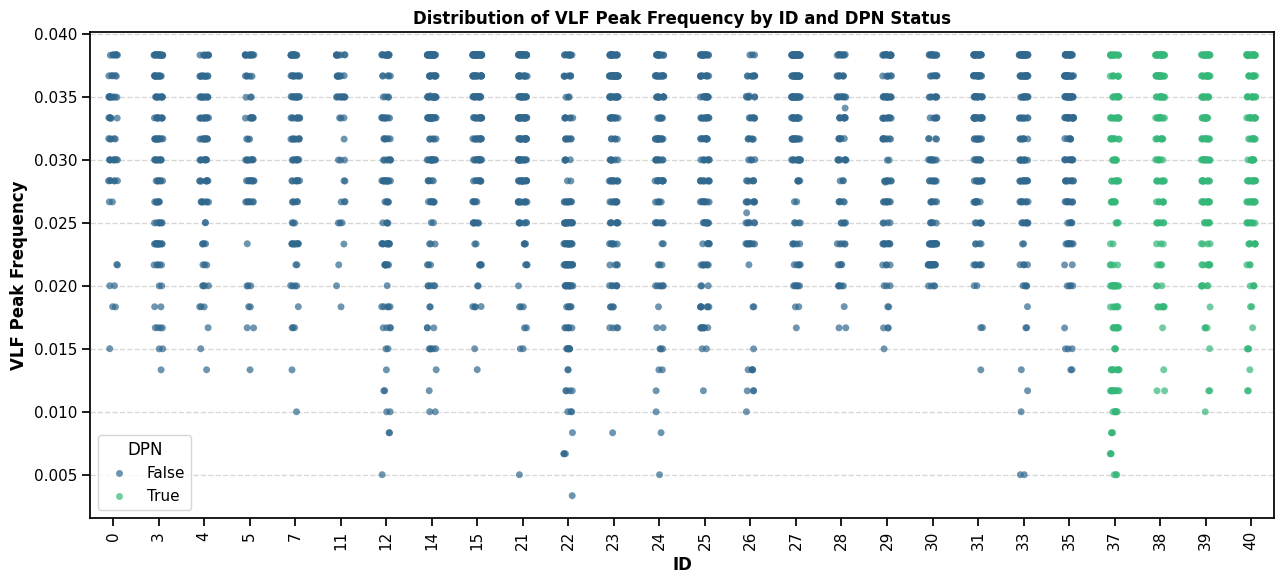

In [135]:
cleaner.draw_metric('VLF Peak Frequency');

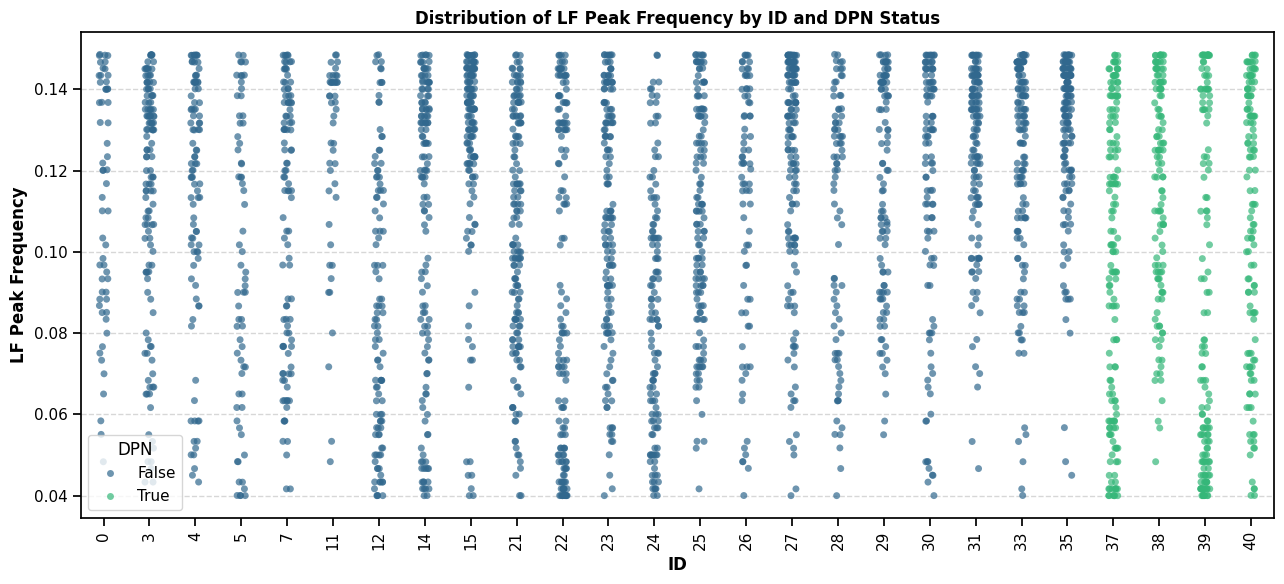

In [136]:
cleaner.draw_metric('LF Peak Frequency');

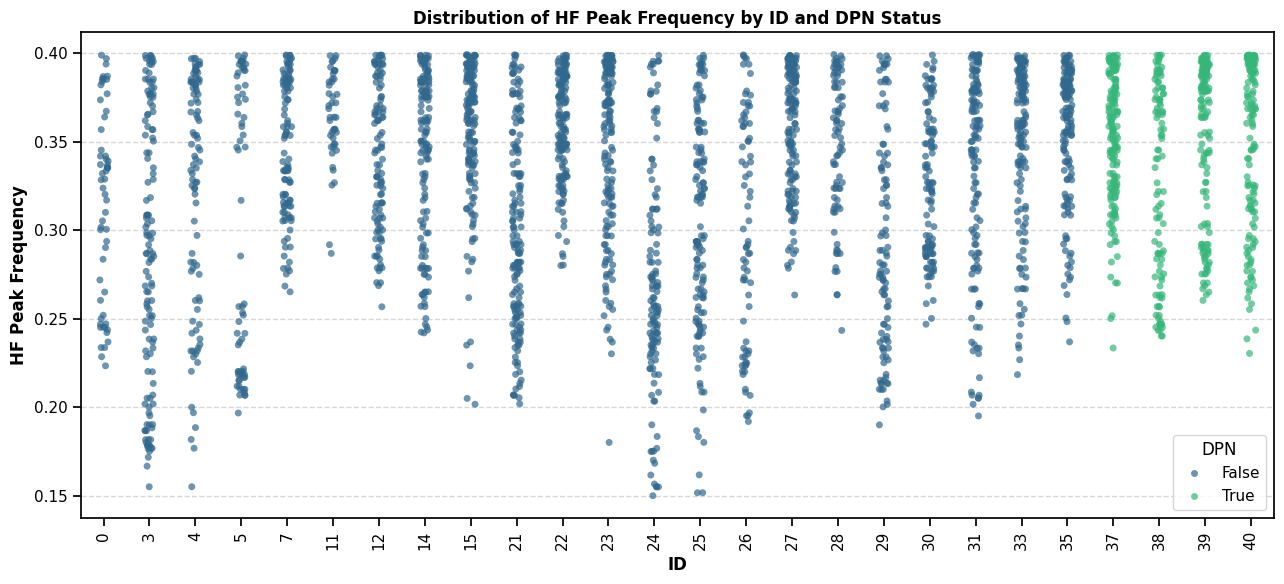

In [137]:
cleaner.lower('HF Peak Frequency', 0.24, [7,14,27,38])
cleaner.draw_metric('HF Peak Frequency');

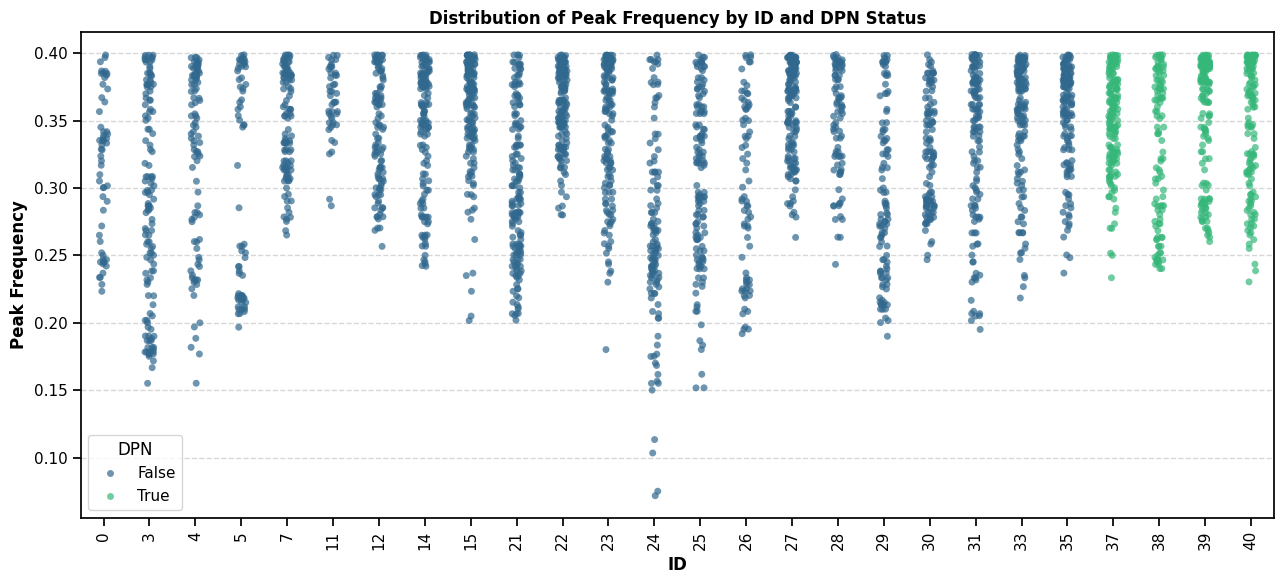

In [148]:
cleaner.draw_metric('Peak Frequency');

## Ratios

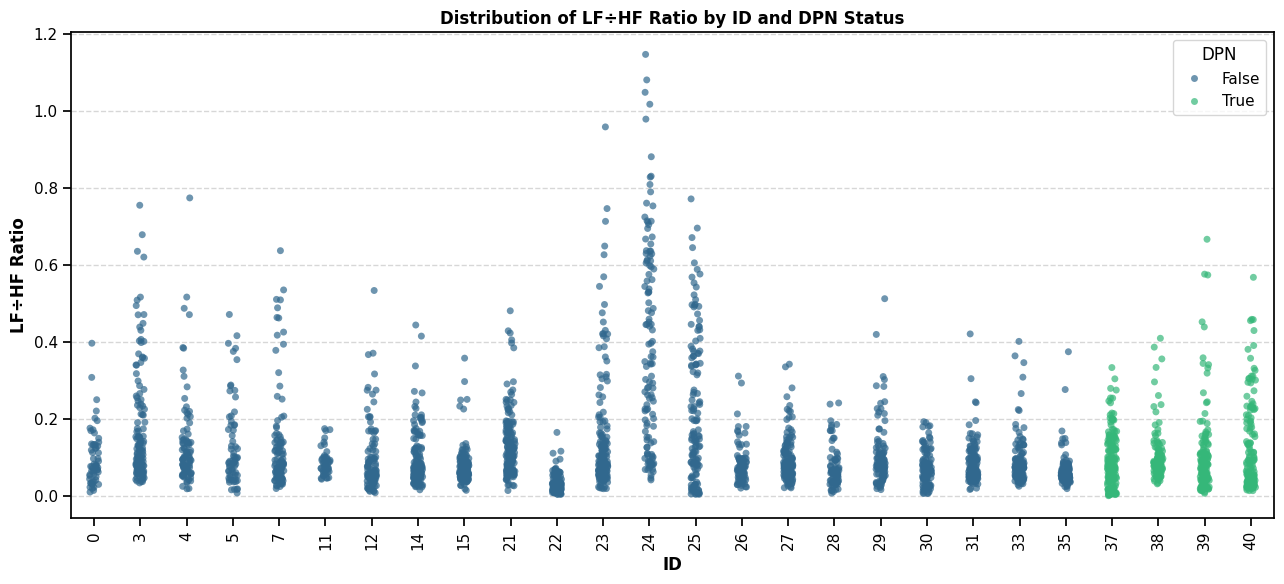

In [138]:
cleaner.upper('LF÷HF Ratio', 1.23)
cleaner.upper('LF÷HF Ratio', 0.65, [7, 33, 35])
cleaner.draw_metric( 'LF÷HF Ratio');

# NonLinear Metrics

In [139]:
non_linear_metrics

['S', 'SD1', 'SD2', 'SD1÷SD2', 'ApEn', 'SampEn', 'DFA α1', 'DFA α2', 'D2']

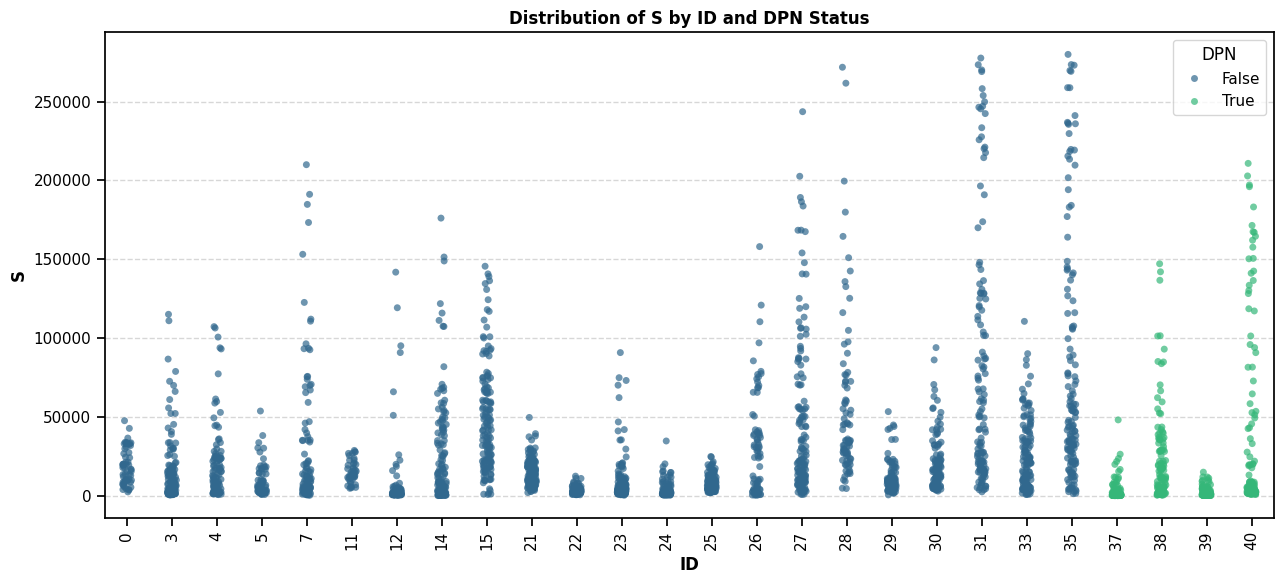

In [140]:
cleaner.draw_metric('S');

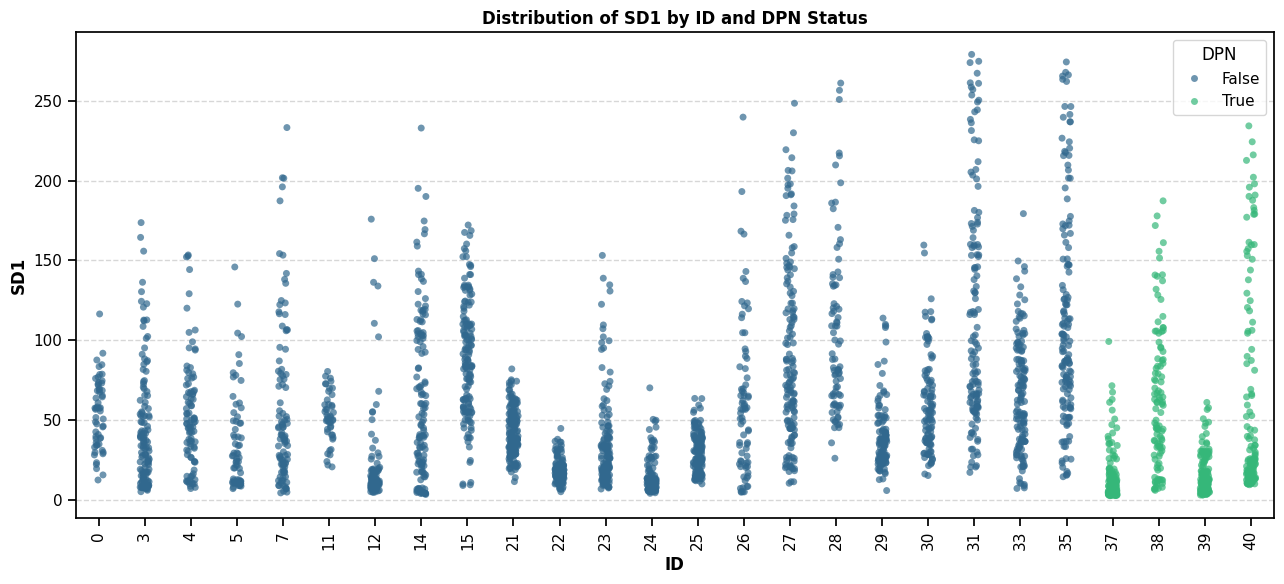

In [141]:
cleaner.draw_metric('SD1');

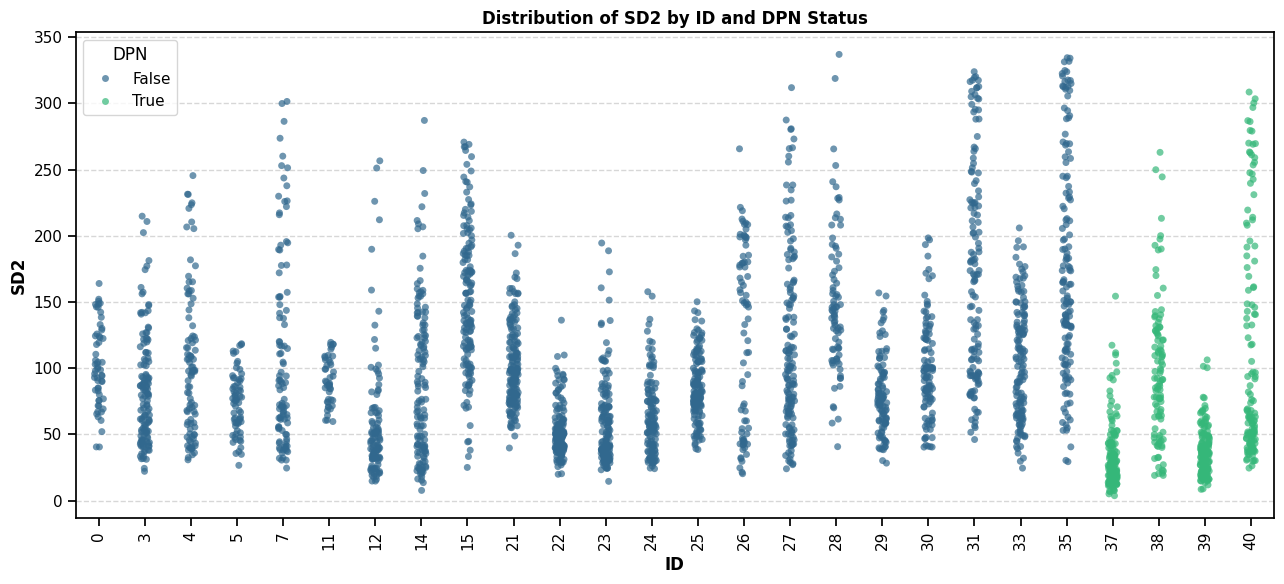

In [142]:
cleaner.draw_metric('SD2');

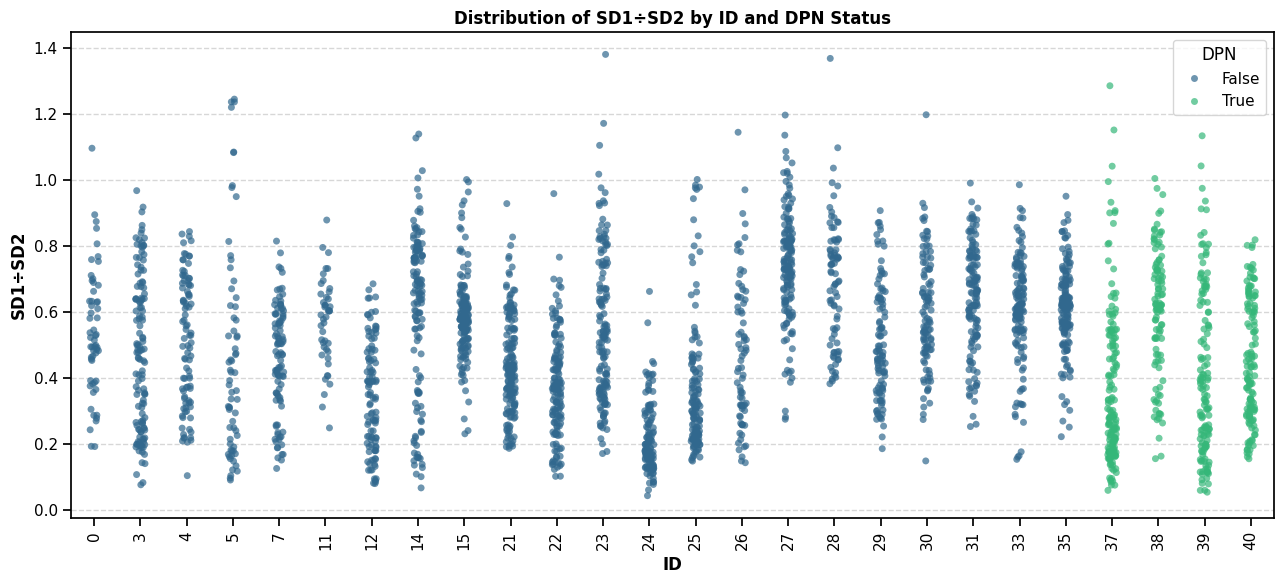

In [143]:
cleaner.draw_metric('SD1÷SD2');

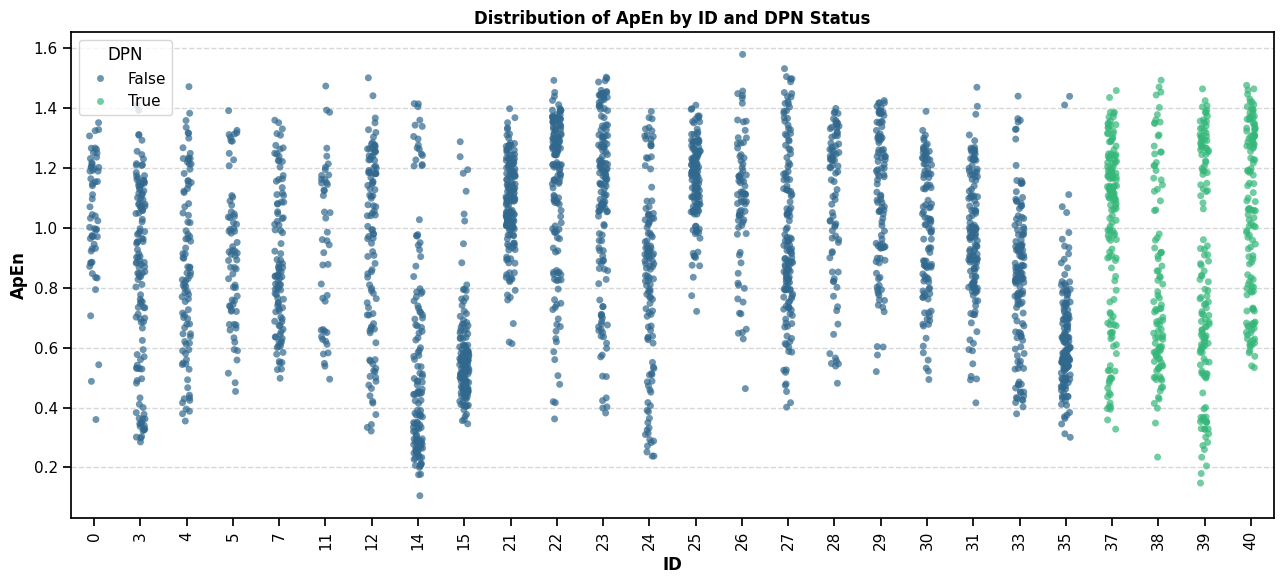

In [144]:
cleaner.lower('ApEn', 0.3,[0, 26, 29, 33])
cleaner.draw_metric('ApEn');

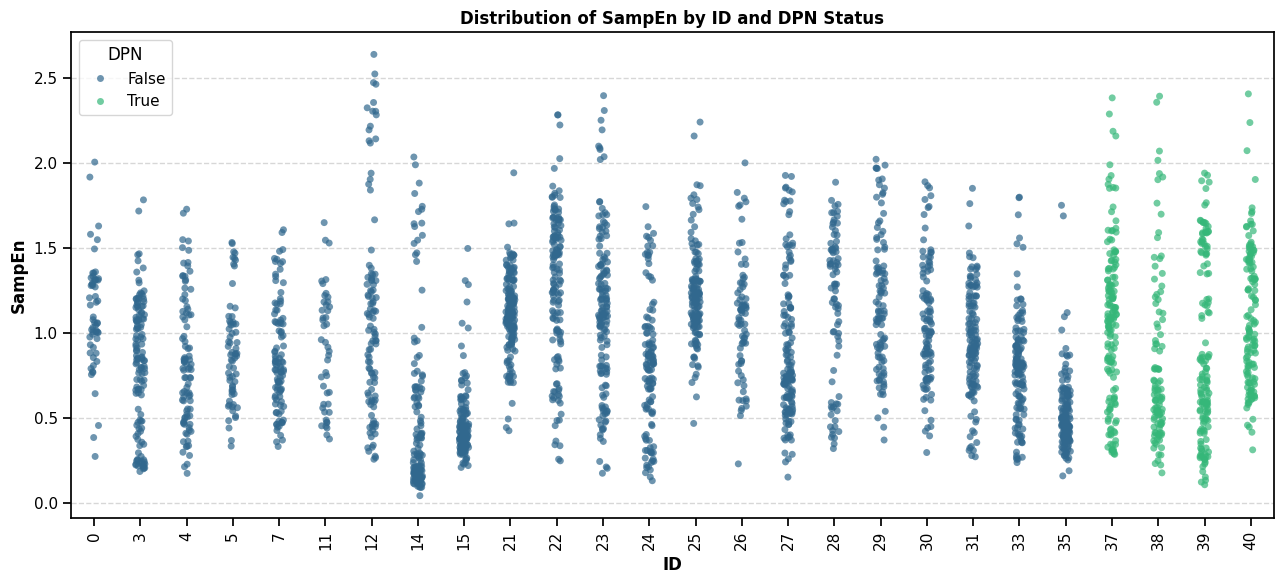

In [145]:
cleaner.upper('SampEn', 2, [3,5,15,27,35])
cleaner.draw_metric('SampEn');

# Save Data

In [146]:
import pickle

data = cleaner.data
# Create a dictionary to store the data and metrics
data_to_pickle = {
    'data': data,
    'indicator_columns': indicator_columns,
    'time_metrics': time_metrics,
    'frequency_metrics': frequency_metrics,
    'non_linear_metrics': non_linear_metrics
}


# Save the dictionary to a pickle file
with open(result_path, 'wb') as file:
    pickle.dump(data_to_pickle, file)